## ThinkDSP

This notebook contains code examples from Chapter 8: Filtering and Convolution

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

In [13]:
# suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)

### Smoothing

As the first example, I'll look at [daily closing stock prices for Facebook](https://finance.yahoo.com/quote/FB/history?period1=1337299200&period2=1585353600&interval=1d&filter=history&frequency=1d), from its IPO on 2012-05-18 to 2020-03-27 (note: the dataset includes only trading days )

In [14]:
if not os.path.exists('FB.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB.csv

In [15]:
import pandas as pd

df = pd.read_csv('FB.csv', header=0, parse_dates=[0])
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-12-08,104.00,106.91,103.95,106.49,20401791
1,2015-12-07,106.48,106.83,104.66,105.61,15474890
2,2015-12-04,104.75,107.73,104.11,106.18,21224721
3,2015-12-03,103.95,106.85,103.35,104.38,23236485
4,2015-12-02,107.00,107.92,105.79,106.07,24429063


In [16]:
df.tail()

,Date,Open,High,Low,Close,Volume
891,2012-05-23,31.37,32.50,31.36,32.00,73721135
892,2012-05-22,32.61,33.59,30.94,31.00,102053826
893,2012-05-21,36.53,36.66,33.00,34.03,168309831
894,2012-05-18,42.05,45.00,38.00,38.23,580587742
895,2012-05-17,-,-,-,38.00,0


Extract the close prices and days since start of series:

In [17]:
close = df['Close']
dates = df['Date']
days = (dates - dates[0]) / np.timedelta64(1,'D')

Make a window to compute a 30-day moving average and convolve the window with the data.  The `valid` flag means the convolution is only computed where the window completely overlaps with the signal.

In [18]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode='valid')
smoothed_days = days[M//2: len(smoothed) + M//2]

Plot the original and smoothed signals.

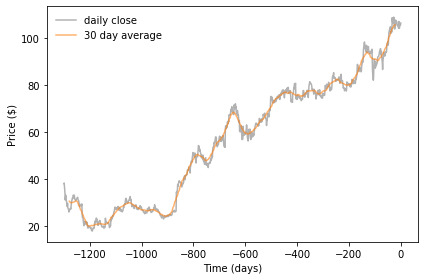

In [19]:
plt.plot(days, close, color='gray', alpha=0.6, label='daily close')
plt.plot(smoothed_days, smoothed, color='C1', alpha=0.6, label='30 day average')

decorate(xlabel='Time (days)', ylabel='Price ($)')

## Smoothing sound signals

Generate a 440 Hz sawtooth signal.

In [20]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)
wave.make_audio()

Make a moving average window.

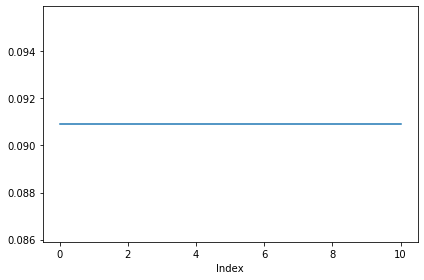

In [21]:
window = np.ones(11)
window /= sum(window)
plt.plot(window)
decorate(xlabel='Index')

Plot the wave.

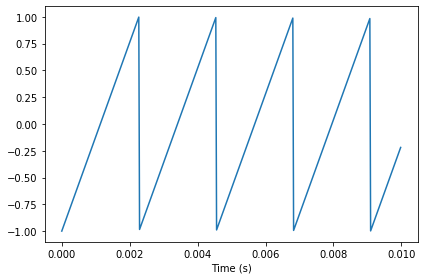

In [22]:
segment = wave.segment(duration=0.01)
segment.plot()
decorate(xlabel='Time (s)')

Pad the window so it's the same length as the signal, and plot it.

In [23]:
def zero_pad(array, n):
    """Extends an array with zeros.

    array: NumPy array
    n: length of result

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

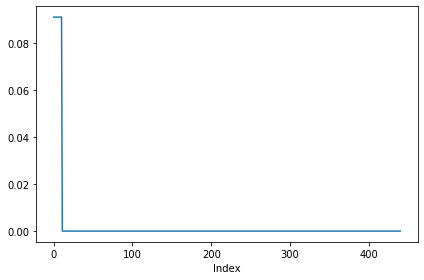

In [24]:
N = len(segment)
padded = zero_pad(window, N)
plt.plot(padded)
decorate(xlabel='Index')

Apply the window to the signal (with lag=0).

In [25]:
prod = padded * segment.ys
np.sum(prod)

-0.9001814882032255

Compute a convolution by rolling the window to the right.

In [33]:
smoothed = np.zeros(N)
rolled = padded.copy()
for i in range(N):
    smoothed[i] = sum(rolled * segment.ys)
    rolled = np.roll(rolled, 1)

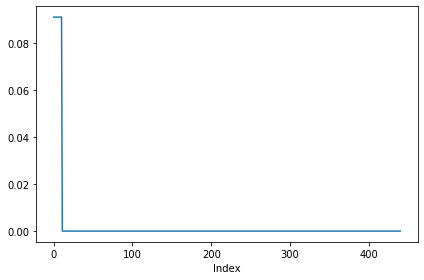

In [35]:
plt.plot(rolled)
decorate(xlabel='Index')

In [37]:
all(rolled==padded)

True

Plot the result of the convolution and the original.

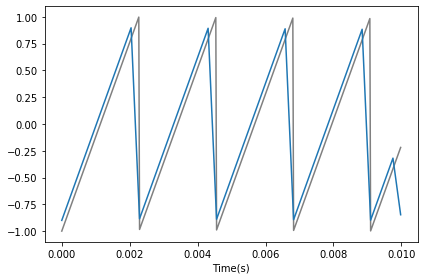

In [38]:
from thinkdsp import Wave

segment.plot(color='gray')
smooth = Wave(smoothed, framerate=wave.framerate)
smooth.plot()
decorate(xlabel='Time(s)')

Compute the same convolution using `numpy.convolve`.

In [39]:
window

array([0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091,
       0.091, 0.091])

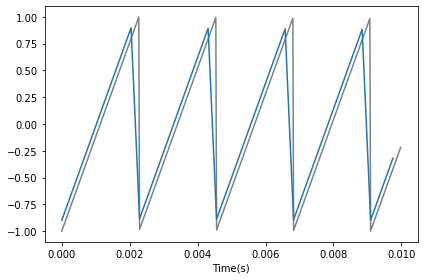

In [40]:
segment.plot(color='gray')
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = Wave(ys, framerate=wave.framerate)
smooth2.plot()
decorate(xlabel='Time(s)')

## Frequency domain

Let's see what's happening in the frequency domain.

Compute the smoothed wave using `np.convolve`, which is much faster than my version above.

In [41]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = Wave(convolved, framerate=wave.framerate)
smooth.make_audio()

Plot spectrums of the original and smoothed waves:

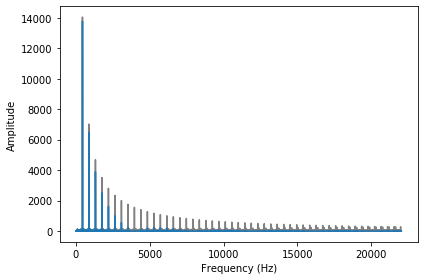

In [42]:
spectrum = wave.make_spectrum()
spectrum.plot(color='gray')

spectrum2 = smooth.make_spectrum()
spectrum2.plot()

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

For each harmonic, compute the ratio of the amplitudes before and after smoothing.

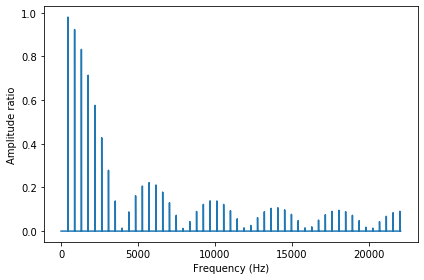

In [43]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<280] = 0

plt.plot(ratio)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

Plot the ratios again, but also plot the FFT of the window.

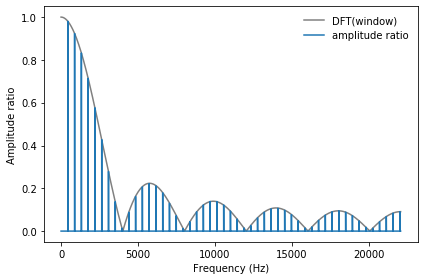

In [44]:
padded =  zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)

plt.plot(np.abs(dft_window), color='gray', label='DFT(window)')
plt.plot(ratio, label='amplitude ratio')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

### Gaussian window

Let's compare boxcar and Gaussian windows.

Make the boxcar window.

In [45]:
boxcar = np.ones(11)
boxcar /= sum(boxcar)

Make the Gaussian window.

In [48]:
import scipy.signal

gaussian = scipy.signal.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

Plot the two windows.

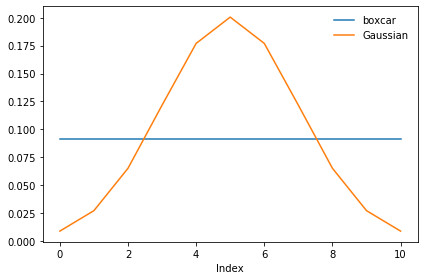

In [49]:
plt.plot(boxcar, label='boxcar')
plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

Convolve the square wave with the Gaussian window.

In [50]:
ys = np.convolve(wave.ys, gaussian, mode='same')
smooth = Wave(ys, framerate=wave.framerate)
spectrum2 = smooth.make_spectrum()

Compute the ratio of the amplitudes.

In [51]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<560] = 0

Compute the FFT of the window.

In [52]:
padded =  zero_pad(gaussian, len(wave))
dft_gaussian = np.fft.rfft(padded)

Plot the ratios and the FFT of the window.

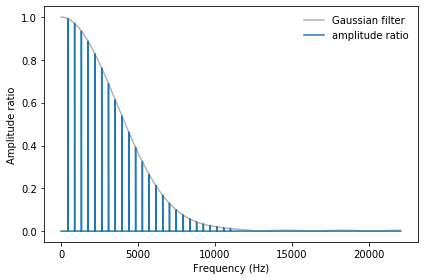

In [53]:
plt.plot(np.abs(dft_gaussian), color='0.7', label='Gaussian filter')
plt.plot(ratio, label='amplitude ratio')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

Combine the preceding example into one big function so we can interact with it.

In [54]:
from thinkdsp import SquareSignal

def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')
    plt.show()

Try out different values of `M` and `std`.

In [55]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

## Convolution theorem

Let's use the Convolution theorem to compute convolutions using FFT.  

I'll use the Facebook data again, and smooth it using `np.convolve` and a 30-day Gaussian window.

I ignore the dates and treat the values as if they are equally spaced in time.

In [56]:
window = scipy.signal.gaussian(M=30, std=6)
window /= window.sum()
smoothed = np.convolve(close, window, mode='valid')

len(close), len(smoothed)

(896, 867)

Plot the original and smoothed data.

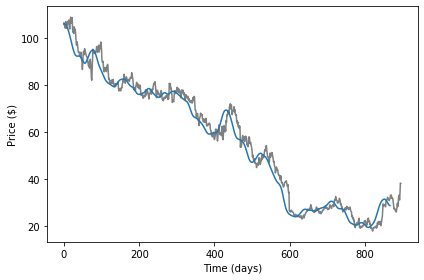

In [57]:
plt.plot(close, color='gray')
plt.plot(smoothed)
decorate(xlabel='Time (days)', ylabel='Price ($)')

Pad the window and compute its FFT.

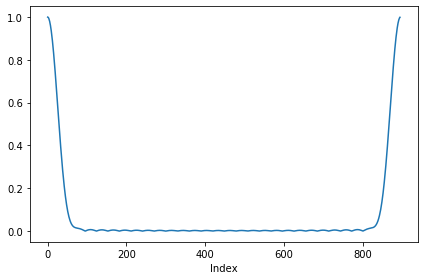

In [58]:
N = len(close)
padded = zero_pad(window, N)
fft_window = np.fft.fft(padded)
plt.plot(np.abs(fft_window))
decorate(xlabel='Index')

Apply the convolution theorem.

In [59]:
fft_signal = np.fft.fft(close)
smoothed2 = np.fft.ifft(fft_signal * fft_window)
M = len(window)
smoothed2 = smoothed2[M-1:]

Plot the two signals (smoothed with numpy and FFT).

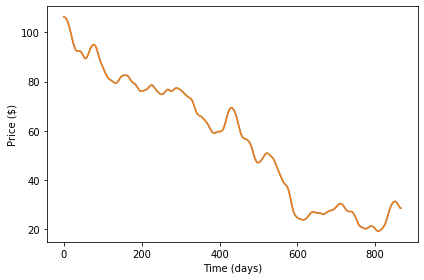

In [60]:
plt.plot(smoothed)
plt.plot(smoothed2.real)
decorate(xlabel='Time (days)', ylabel='Price ($)')

Confirm that the difference is small.

In [61]:
diff = smoothed - smoothed2
np.max(np.abs(diff))

4.2831562455566367e-14

`scipy.signal` provides `fftconvolve`, which computes convolutions using FFT.

In [62]:
smoothed3 = scipy.signal.fftconvolve(close, window, mode='valid')

Confirm that it gives the same answer, at least approximately.

In [63]:
diff = smoothed - smoothed3
np.max(np.abs(diff))

4.263256414560601e-14

We can encapsulate the process in a function:

In [64]:
def fft_convolve(signal, window):
    fft_signal = np.fft.fft(signal)
    fft_window = np.fft.fft(window)
    return np.fft.ifft(fft_signal * fft_window)

And confirm that it gives the same answer.

In [65]:
smoothed4 = fft_convolve(close, padded)[M-1:]
len(smoothed4)

867

In [66]:
diff = smoothed - smoothed4
np.max(np.abs(diff))

4.2831562455566367e-14

### Autocorrelation

We can also use the convolution theorem to compute autocorrelation functions.

Compute autocorrelation using `numpy.correlate`:


In [67]:
corrs = np.correlate(close, close, mode='same')
corrs[:7]

array([1270328.926, 1275904.275, 1281642.575, 1287703.809, 1293716.583,
       1299686.728, 1305804.721])

Compute autocorrelation using my `fft_convolve`.  The window is a reversed copy of the signal.  We have to pad the window and signal with zeros and then select the middle half from the result.

In [68]:
def fft_autocorr(signal):
    N = len(signal)
    signal = zero_pad(signal, 2*N)
    window = np.flipud(signal)

    corrs = fft_convolve(signal, window)
    corrs = np.roll(corrs, N//2+1)[:N]
    return corrs

Test the function.

In [69]:
corrs2 = fft_autocorr(close)
corrs2[:7]

array([1270328.926+0.j, 1275904.275-0.j, 1281642.575-0.j, 1287703.809-0.j,
       1293716.583+0.j, 1299686.728-0.j, 1305804.721+0.j])

Plot the results.

(896, 896)

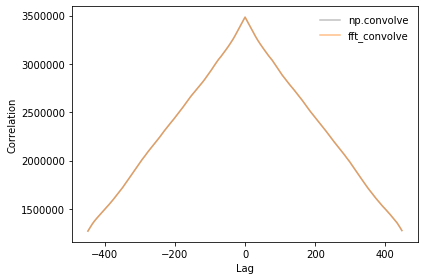

In [70]:
lags = np.arange(N) - N//2
plt.plot(lags, corrs, color='gray', alpha=0.5, label='np.convolve')
plt.plot(lags, corrs2.real, color='C1', alpha=0.5, label='fft_convolve')
decorate(xlabel='Lag', ylabel='Correlation')
len(corrs), len(corrs2)

Confirm that the difference is small.

In [71]:
diff = corrs - corrs2.real
np.max(np.abs(diff))

1.3969838619232178e-09